# India Choropleth Map — Accident Counts by State/UT (2021)

This notebook plots accident counts on an **India map** (states and union territories) using a GeoJSON boundary file and the Indian Accident Dataset.

**Data:** States + UTs only (cities are excluded from the map).

## 1. Setup and load accident data

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv("Dataset/Indian-Accident-Dataset.csv")
count_cols = [c for c in df.columns if c not in ['Type', 'Region']]
df['Total_Accidents'] = df[count_cols].sum(axis=1)

# Keep only State and UT for the map (exclude City)
map_df = df[df['Type'].isin(['State', 'UT'])].copy()
map_df = map_df[['Type', 'Region', 'Total_Accidents']].reset_index(drop=True)
print(f"Regions to map: {len(map_df)} ({len(map_df[map_df['Type']=='State'])} States, {len(map_df[map_df['Type']=='UT'])} UTs)")
print(map_df.head(10))

Regions to map: 36 (28 States, 8 UTs)
    Type             Region  Total_Accidents
0  State     Andhra Pradesh            16044
1  State  Arunachal Pradesh              391
2  State              Assam             4524
3  State              Bihar            15405
4  State       Chhattisgarh            17522
5  State                Goa              596
6  State            Gujarat            22051
7  State            Haryana            15491
8  State   Himachal Pradesh             3003
9  State          Jharkhand             7368


## 2. Load India states GeoJSON and merge

We use a public GeoJSON where each feature has a state name in property **`ST_NM`**. We map our **Region** names to match (with a small mapping for any naming differences).

In [8]:
import urllib.request
import json

GEOJSON_URL = "https://gist.githubusercontent.com/jbrobst/56c13bbbf9d97d187fea01ca62ea5112/raw/e388c4cae20aa53cb5090210a42ebb9b765c0a36/india_states.geojson"

with urllib.request.urlopen(GEOJSON_URL) as r:
    geojson = json.load(r)

# GeoJSON state names (property is ST_NM)
geo_names = [f['properties'].get('ST_NM') or f['properties'].get('st_nm') for f in geojson['features']]
print("Sample GeoJSON names:", geo_names[:5])
print("Total features:", len(geojson['features']))

Sample GeoJSON names: ['Arunachal Pradesh', 'Assam', 'Chandigarh', 'Karnataka', 'Manipur']
Total features: 36


In [9]:
# Map our Region names to GeoJSON ST_NM (handle naming differences)
region_to_geo = {
    'Dadra and Nicobar Haveli and Daman and Diu': 'Dadra and Nagar Haveli and Daman and Diu',  # common GeoJSON name
}

map_df['geo_name'] = map_df['Region'].replace(region_to_geo)
geo_set = set(geo_names)
matched = map_df['geo_name'].isin(geo_set)
print("Matched to GeoJSON:", matched.sum())
if not matched.all():
    print("Unmatched regions:", map_df.loc[~matched, 'Region'].tolist())

Matched to GeoJSON: 34
Unmatched regions: ['Andaman and Nicobar Islands', 'Jammu and Kashmir']


## 3. Choropleth with GeoPandas

In [10]:
try:
    import geopandas as gpd
except ImportError:
    print("Run: pip install geopandas")
    raise

# Build GeoDataFrame from GeoJSON
gdf = gpd.GeoDataFrame.from_features(geojson['features'], crs='EPSG:4326')
name_col = 'ST_NM' if 'ST_NM' in gdf.columns else 'st_nm'
gdf = gdf.rename(columns={name_col: 'ST_NM'})

# Merge accident totals (only matched regions get values)
accident_by_geo = map_df.set_index('geo_name')['Total_Accidents']
gdf['Total_Accidents'] = gdf['ST_NM'].map(accident_by_geo)
gdf['Total_Accidents'] = gdf['Total_Accidents'].fillna(0).astype(int)

print(gdf[['ST_NM', 'Total_Accidents']].head(10))

               ST_NM  Total_Accidents
0  Arunachal Pradesh              391
1              Assam             4524
2         Chandigarh              379
3          Karnataka            25276
4            Manipur              277
5          Meghalaya              566
6            Mizoram              232
7           Nagaland               73
8             Punjab            10444
9          Rajasthan            23196


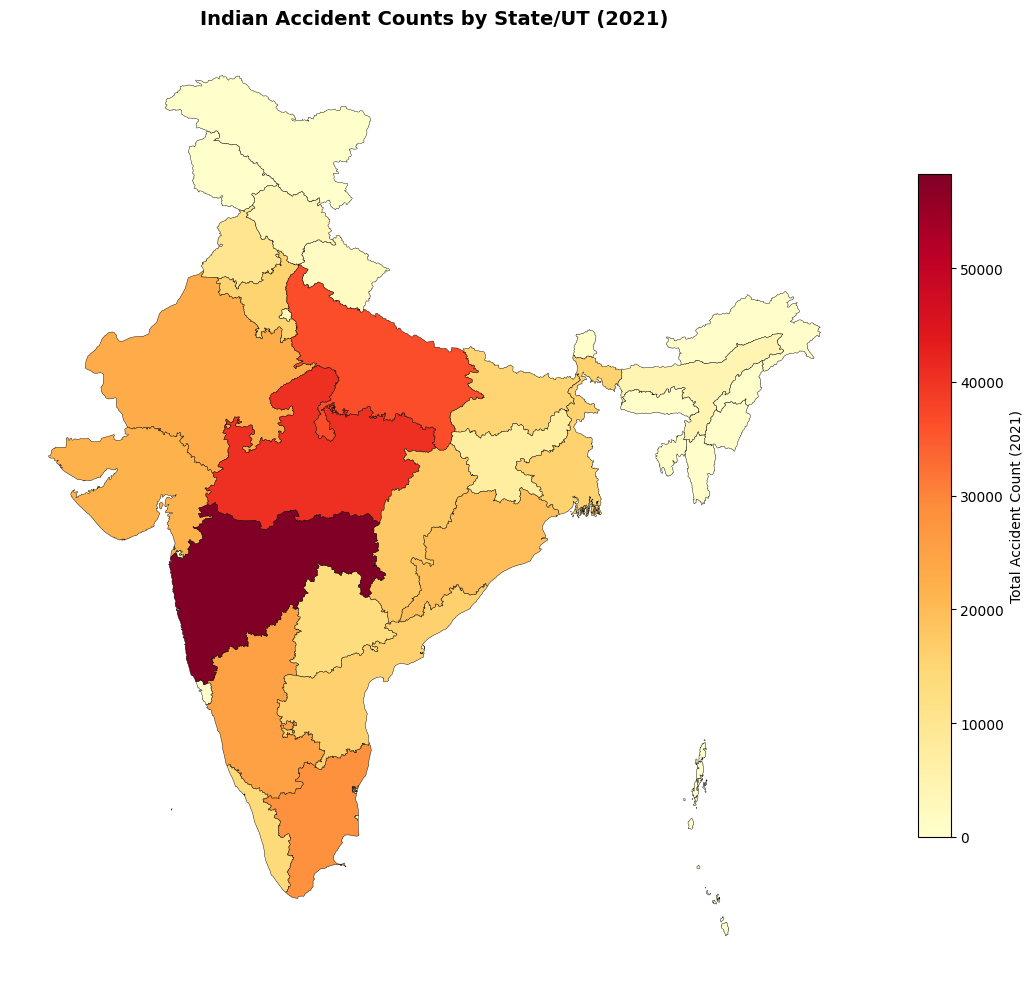

In [11]:
fig, ax = plt.subplots(figsize=(12, 10))
gdf.plot(ax=ax, column='Total_Accidents', legend=True, cmap='YlOrRd', edgecolor='black', linewidth=0.3,
         legend_kwds={'label': 'Total Accident Count (2021)', 'shrink': 0.7})
ax.set_title('Indian Accident Counts by State/UT (2021)', fontsize=14, fontweight='bold')
ax.axis('off')
plt.tight_layout()
plt.show()

## 4. Interactive map (Folium)

Run the cell below to create an interactive choropleth and save it as `india_accident_map.html`. Requires `folium` (`pip install folium`).

In [12]:
import folium
from folium.plugins import Choropleth
m = folium.Map(location=[20.5, 78], zoom_start=4)
Choropleth(
    geo_data=geojson,
    data=accident_by_geo.to_dict(),
    key_on='properties.ST_NM',
    fill_color='YlOrRd',
    fill_opacity=0.7,
    line_opacity=0.3,
    legend_name='Total Accident Count (2021)'
).add_to(m)
m.save('india_accident_map.html')
print('Saved to india_accident_map.html')
m

/Users/lzycdrtj/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


ImportError: cannot import name 'Choropleth' from 'folium.plugins' (/Users/lzycdrtj/Library/Python/3.9/lib/python/site-packages/folium/plugins/__init__.py)